TensorFlow は大規模な機械学習向けのオープンソースの数値計算ライブラリです．
基本的な動作原理は単純で
1. Pythonで計算したいグラフを定義して(Figure 9-1)
2. TensorFlowが1.で作ったグラフを受け取って
3. 最適化済みC++コードを使って効率的に計算します
という手順を踏むだけで計算が実行できます．

また重要なこととして，グラフをいくつかのかたまりに分解して複数のCPU or GPUを使って並列計算が行えます(Figure 9-2)．さらに，TensorFlowは 分散コンピューティングをサポートしてて, たとえば巨大なNeural Networkを何百ものサーバを使って計算することもできます(Chapter12で詳説). これを利用すれば数百万ものパラメータ・変数，数十億のインスタンスをもつNetworkに対しても計算ができます．
他の機械学習ライブラリと比較してTensorflowは，スッキリデザイン(clean design),スケーラビリティ(scalability),柔軟性(flexibility),ドキュメントの豊富さが強みです．

# 9.1 Installation
# 9.2 Creating Your First Graph and Running It in a Session
次のコードでFigure 9-1のグラフが作れます．

In [1]:
import tensorflow as tf
x = tf.Variable(3, name="x")
y = tf.Variable(4, name="y")
f = x*x*y + y + 2

/Users/syuheyk/.pyenv/versions/anaconda3-4.3.1/envs/py3.6.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


注意すべき点は，このコードは実態はグラフを作っただけで，計算しているように見えてなにも計算していないことです．変数(```x,y```)は初期化すらされていません．このグラフを使って計算するには，Tensorflowの*session*を開けて変数を初期化し，```f```を評価しなければいけません．
TensorflowのsessionはCPUやGPUなどのデバイスに変数を乗せるオペレーションなどを全部面倒みてくれます．次のコードでは，先ほどの変数(```x,y```)と```f```に対して，sessionを作り，変数を初期化し，```f```を評価し，クローズするという一連の流れを行います．

In [2]:
sess = tf.Session()
sess.run(x.initializer)
sess.run(y.initializer)
result = sess.run(f)
print(result)
print(3*3*4 + 4 + 2)
sess.close()

42
42


いちいち```sess.run()```をしなければならないのは面倒なので，以下のように書くことで先ほどのコードと同じことができます．

In [3]:
with tf.Session() as sess:
    x.initializer.run()
    y.initializer.run()
    result = f.eval()

```with```ブロック内ではデフォルトのsessionが適用され，
- ```x.initializer.run()``` は ```tf.get_default_session(). run( x.initializer)```と同一
- ```f.eval()```は```tf.get_default_session(). run( f)```と同一
と解釈されます． これでコードがみやすくなるうえに，```with```ブロックの終わりで自動的にsessionが終了します．
また，各変数に対してそれぞれinitializerを走らせるのもの面倒なので，代わりに```global_variables_initializer()```を使うことができます．これもコードを実行してすぐに初期化するのではないことに注意してください．この関数では実行時に全てのノードを作ってくれます．

In [4]:
init = tf.global_variables_initializer()
# prepare an init mode

with tf.Session() as sess:
    init.run() # actually initialize all the variables
    result = f.eval()    

またjupyterやPythonシェル内では```InteractiveSession```を作る方が便利だったりすることがあります．先ほどのコードのような普通の```session```との違いは```InteractiveSession```は作られたときに自動的にデフォルトのsessionになることで，したがって```with```ブロックを書く必要はありません．

In [5]:
sess = tf.InteractiveSession()
init.run()
result = f.eval()
sess.close()

TensorFlowの典型的なプログラムは2つの部分に分けることができます．
1. a computation graphを作るフェーズ (構築フェーズ：the construction phase)  
訓練したい機械学習モデルを表すcomputation graphを作ります．
2. そのグラフの計算を走らせるフェーズ (実行フェーズ：the execution phase)  
訓練する手順を繰り返しループさせ，モデルを改良していきます．
以下では事例を元に試してみましょう．

# 9.3 Managing Graphs
ノードを作ると自動的にデフォルトのグラフに追加されます．例えば次のコードでグラフにノードを追加したとします．

In [8]:
x1 = tf.Variable( 1)
x1. graph is tf.get_default_graph()

True

だいたいのケースでは問題ないんですが，たまにいくつかの独立したグラフを使っているときに支障をきたします．
別のグラフとして上記を使いたい場合は新しいグラフを作って```with```ブロック内で一時的にデフォルトグラフとして使うことができます．

In [9]:
graph = tf.Graph()
with graph.as_default():
    x2 = tf.Variable( 2)
x2. graph is graph

True

In [10]:
x2. graph is tf.get_default_graph()

False

# 9.4 Lifecycle of Node Value
ノードを評価するとき，TensorFlowは別のノードに依存しているノードを自動的に探してきて，一番大元にあたるノードから評価していきます．例えば次のコードを考えます．

In [11]:
w = tf.constant(3)
x = w + 2
y = x + 5
z = x * 3

with tf.Session() as sess:
    print( y.eval()) # 10
    print( z.eval()) # 15

10
15


最初の4行で簡単なグラフを定義しています．
sessionが始まると，```y.eval()```で```y```の評価を，```z.eval()```で```z```の評価を始めます．
- ```y```の評価ではTensorFlowが```y```が```x```に依存している，```x```が```w```に依存しているということを自動的に検出してきて，```w```,```x```,```y```という順に評価していき，```y```の値を返します． 
- ```z```の評価でも同様に```w```,```x```,```z```という順に評価していきますが，ここで注意しなければいけないのは，```y```を評価するさいに使った```w```と```x```の値は再利用しないということです．つまり上のコードでは```w```と```x```は2回づつ評価されます．

どうなっているかというと，いくつかのグラフの評価を走らせる場合，あるグラフから別のグラフの評価に移る際に全てのノードの値を消去してしまいます(queues and readers also maintain some state, as we will see in Chapter 12). 
一方，変数はinitializerが走った後，sessionが閉じられるまで消えずに存在し続けるため，変数の値はあるグラフから別のグラフの評価の間で保持されます．```w```と```x```の値を再評価しないで```y```と```z```を効率的に評価するには，次のコードのように1つのグラフを走らせる間に```y```と```z```を評価すればよいです．

In [12]:
with tf.Session() as sess:
    y_val, z_val = sess.run([ y, z])
    print( y_val) # 10
    print( z_val) # 15

10
15


# 9.5 Linear Regression with TensorFlow
TensorFlowのoperationsはopsと省略します．
opsはインプット何個でもアウトプット何個でも大丈夫です．たとえば，
- 和と積は2つのインプットに対して1つのアウトプットを出力します．
- 定数と変数はインプットをとりません，こうしたopsをsource opsといいます．
これらのインプットとアウトプットはtensorと呼ばれる多次元配列です．
Numpyと同じでtensorも型(type)と形(shape)を持ちますが，実はPython APIのtensorはNumpy ndarrayで表現されています．

これまでの例ではtensorはスカラー値を保持してましたが，どんな形の配列でも計算できます．
たとえば次のコードは2次元配列を使って(Chapter2で使った)the California housing データセットで線形回帰を行います．
手順としては
1. データセットを変数に代入します
2. すべての変数(フィーチャ)にbias input($x_0 = 1$)を加えます(NumPyを使っているのでこれはコードのところで実行)
3. ```X```と```y```という2つのノードを作成し，これらを使って```theta```　を定義します． 
4. sessionを作成し，```theta```を評価します．
という流れで計算をしています．

補足：
行列関数：transpose(), matmul(), matrix_inverse() の意味は名前からわかると思いますが，これらはTensorflowが提供している関数です．この関数も使われた直後に実行されるのではなく，グラフにノードを作るだけで，グラフが実行される中でこれらの関数も実行されます．また，```theta```の定義は正規方程式の解 $\theta=X^T\cdot X)^{-1}\cdot X^T\cdot y$です．(Chapter 4を参照). 

In [13]:
import numpy as np
from sklearn.datasets import fetch_california_housing

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)
reset_graph()

housing = fetch_california_housing()
m, n = housing.data.shape
housing_data_plus_bias = np.c_[np.ones((m, 1)), housing.data]

X = tf.constant(housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
XT = tf.transpose(X)
theta = tf.matmul(tf.matmul(tf.matrix_inverse(tf.matmul(XT, X)), XT), y)

with tf.Session() as sess:
    theta_value = theta.eval()
    

print(theta_value)

[[ -3.74651413e+01]
 [  4.35734153e-01]
 [  9.33829229e-03]
 [ -1.06622010e-01]
 [  6.44106984e-01]
 [ -4.25131839e-06]
 [ -3.77322501e-03]
 [ -4.26648885e-01]
 [ -4.40514028e-01]]


Numpyを使って正規方程式の解を計算する代わりに上のコードを使うメリットは，Tensorflowはちゃんと設定しておけば，勝手にGPUなどを使ってくれるところです(Chapter 12を参照).

# 9.6 Implementing Gradient Descent
ここでは正規方程式の解を使うのではなくて，Tensorflowを使ってBatch Gradient Descent (Chapter 4参照)をやってみましょう！ 
はじめに(9.6.1で) gradientを手動で計算してやる方法と，次に(9.6.2で)Tensorflowのautodiffを使ってgradientを自動で計算し，最後に(9.6.3で)TensorFlowのout-of-the-box optimizerを使ってgradient decentりましょう！

## 9.6.1 Implementing Gradient Descent
gradient decentするには，事前にフィーチャベクトルをスケーリングしとかないといけません．

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_housing_data = scaler.fit_transform(housing.data)
scaled_housing_data_plus_bias = np.c_[np.ones((m, 1)), scaled_housing_data]

In [15]:
print(scaled_housing_data_plus_bias.mean(axis=0))
print(scaled_housing_data_plus_bias.mean(axis=1))
print(scaled_housing_data_plus_bias.mean())
print(scaled_housing_data_plus_bias.shape)

[  1.00000000e+00   6.60969987e-17   5.50808322e-18   6.60969987e-17
  -1.06030602e-16  -1.10161664e-17   3.44255201e-18  -1.07958431e-15
  -8.52651283e-15]
[ 0.38915536  0.36424355  0.5116157  ..., -0.06612179 -0.06360587
  0.01359031]
0.111111111111
(20640, 9)


次のコードで本チャンのgradient decentをします，内容はだいたい読めばわかるでしょう．いくつか補足をしておきます：
- random_uniform()は乱数のtensorをグラフのノードに作る関数です． Numpyのrand()みたいに形(shape)と値のレンジを指定する必要があります．
- assign()は変数に新たな値を代入する関数です．下の例ではBatch Gradient Decentの$\theta^{(\text{next step})}=\theta-\eta\nabla_\theta\text{MSE}(\theta)$を実装しています．
- mainループは訓練を何回も繰り返し，100回ごとに回ごとに，その時のmseを返します．毎回mseが小さくなることを確認してください．

In [16]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
gradients = 2/m * tf.matmul(tf.transpose(X), error)
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147


## 9.6.2 Using autodiff
前節のコードはそれはそれでうまくいくんですが，コスト関数(MSEのこと)のgradientが数学的にわかってないと使えません．
線形回帰なら簡単ですが，たとえばDeep Neural Networkとかでgradientを計算するのは至難の業です．
自動微分を使って偏微分を計算することもできますが，結果出来上がるコードは必ずしも効率的なものではありません．

TensorFlowのautodiffを使えば自動的かつ効率的にgradientを計算してくれます．
上のコードの```gradients = ...```の行の右辺を```tf.gradient(mse, [theta])[0]```と書き換えればOKです．

In [17]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# ↓ここを書き換えました
gradients = tf.gradients(mse, [theta])[0]
# ↑ここを書き換えました
training_op = tf.assign(theta, theta - learning_rate * gradients)

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147
Best theta:
[[ 2.06855249]
 [ 0.88740271]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145277]
 [-0.6375277 ]]


gradients()関数はops(```mse```)と変数のリスト(```theta```)を引数に取り，第一引数のopsのgradientを第二変数の各変数に対応して計算し，結果のopsのリスト(変数1つに対して1ops)を作ります．今回のコードでは```theta```に関するMSEのgradientを計算してくれます．
gradientの計算には主に4つのアプローチがあって，Table9-2にまとめていますが，TensorFlowはreverse-mode autodiffを使っていて，インプットが多くアウトプットが少ない場合は効率的で正確な手法なので，バッチリです．Neural Networkのときも同じような状況なので，バッチリです．
reverse-mode autodiffでは，$n_{\text{outputs}}+1$個のグラフトラバーサルの全てに対するアウトプットの偏微分を計算してくれます．

## 9.6.3 Using an Optimizer
TensorflowはGradient Decent Optimizerを含むout of the boxのoptimizersをいくつか提供しているので，それを使うこともできます．
そのときは```gradients = ...```と```raining_op = ...```を入れ替えて，次のコードのようにすればOKです．

In [18]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# ↓ここを書き換えました
optimizer = tf.train.GradientDescentOptimizer( learning_rate = learning_rate)
training_op = optimizer.minimize( mse)
# ↑ここを書き換えました
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147
Best theta:
[[ 2.06855249]
 [ 0.88740271]
 [ 0.14401658]
 [-0.34770882]
 [ 0.36178368]
 [ 0.00393811]
 [-0.04269556]
 [-0.66145277]
 [-0.6375277 ]]


別のoptimizerを使いたいときは```optimizer = ...```の一行を書き換えればOKです．
たとえば，Gradient Decent Optimizerより早く収束するMomentum Optimizerを使うには次のようにします(詳しくはChapter11を参照)．

In [19]:
reset_graph()

n_epochs = 1000
learning_rate = 0.01

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
# ↓ここを書き換えました
optimizer = tf.train.MomentumOptimizer( learning_rate = learning_rate, momentum = 0.9)
# ↑ここを書き換えました
training_op = optimizer.minimize( mse)
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())
        sess.run(training_op)
    
    best_theta = theta.eval()

print("Best theta:")
print(best_theta)

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.530564
Epoch 200 MSE = 0.525011
Epoch 300 MSE = 0.524411
Epoch 400 MSE = 0.524333
Epoch 500 MSE = 0.524322
Epoch 600 MSE = 0.524321
Epoch 700 MSE = 0.524321
Epoch 800 MSE = 0.524321
Epoch 900 MSE = 0.524321
Best theta:
[[ 2.06855798]
 [ 0.82962859]
 [ 0.11875337]
 [-0.26554456]
 [ 0.30571091]
 [-0.00450251]
 [-0.03932662]
 [-0.89986444]
 [-0.87052065]]


# 9.7 Feeding Data to the Training Algorithm
前節のコードをMini-batch Gradient Decentにしましょう！必要なことは```x```と```y```を毎回のイテレーションで更新することですが，プレースホルダノード(placeholder nodes)を使うことで，訓練中に訓練データをTensorflowに渡すことができます．
プレースホルダノードのポイントは以下の感じです．
- placeholder()で使えます．
- アウトプットのtensorの型を指定します．
- 実行時の返り値を指定しないとエラーが出力されます．
- オプション引数でアウトプットの形(shape)を指定することができます．
- 次元(dimension)に```None```を指定すると，どんなサイズでも扱えます．

たとえば，次のコードは以下の手順で計算します．
- プレースホルダ```A```とノード```B = A + 5```を作ります．
- ```B.eval```で```B```を評価するとき，```A```を```feed_dict```を通して```eval()```メソッドに渡すことで，```A``の値を指定します．
- ```A```を渡すとときには，```A```は$2$次元であること，$3$カラムあること(```3```で指定)，行数はいくつでもよいこと(```None```で指定)に注意してください．

In [20]:
A = tf.placeholder( tf.float32, shape =( None, 3))
B = A + 5
with tf.Session() as sess:
    B_val_1 = B.eval( feed_dict ={ A: [[ 1, 2, 3]]})
    B_val_2 = B.eval( feed_dict ={ A: [[ 4, 5, 6], [7, 8, 9]]}) 
    
print( B_val_1)
print( B_val_2)

[[ 6.  7.  8.]]
[[  9.  10.  11.]
 [ 12.  13.  14.]]


Mini-batch Gradient Decentを実装するには次の手順を踏みます．
1. 構築フェーズの`
``x```と```y```をプレースホルダノードに変え，batchサイズとbatch数を決めます．
2. 実行フェーズでmini-batchを毎回代入し，```feed_dict```パラメータで```X```と```y```を作ります．

In [21]:
# 1.のコード
X = tf.placeholder(tf.float32, shape=(None, n+1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
batch_size = 100
n_batches =int(np.ceil(m / batch_size)) 

In [22]:
# そのほかもろもろの準備
n_epochs = 100
learning_rate = 0.01

theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

In [23]:
# 2.のコード
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  # not shown in the book
    indices = np.random.randint(m, size=batch_size)  # not shown
    X_batch = scaled_housing_data_plus_bias[indices] # not shown
    y_batch = housing.target.reshape(-1, 1)[indices] # not shown
    return X_batch, y_batch

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()

In [24]:
print(best_theta)

[[ 2.0544672 ]
 [ 0.82970113]
 [ 0.10713524]
 [-0.31074819]
 [ 0.24564511]
 [-0.00222412]
 [-0.01061389]
 [-0.89121586]
 [-0.87524796]]


# 9.8 Saving and Restoring Models
モデルの訓練が終わったらパラメータを保存したいし，実行中のクラッシュに備えて訓練中にチェックポイントを保存しときたいですよね．
Tensorflowでは，構築フェーズの終わりにSaverノードを作り，実行フェーズで```save()```メソッドを保存したい時に実行すれば保存できます．
保存する内容はモデルとセッション，チェックポイントファイルのパスです．  
次のコードはGradient Decent Optimizerの例でチェックポイントを保存する例です．(テキストと違い，```tfcheckpoint```フォルダを実行フォルダの下に作り，そこに保存しています．)

In [25]:
reset_graph()

n_epochs = 1000                                                                       
learning_rate = 0.01                                                                  

X = tf.constant(scaled_housing_data_plus_bias, dtype=tf.float32, name="X")            
y = tf.constant(housing.target.reshape(-1, 1), dtype=tf.float32, name="y")            
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")                                      
error = y_pred - y                                                                 
mse = tf.reduce_mean(tf.square(error), name="mse") 
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)        
training_op = optimizer.minimize(mse)                                               

init = tf.global_variables_initializer()
# ↓構築フェーズの最後にsaver作成
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 100 == 0:
            print("Epoch", epoch, "MSE =", mse.eval())                                
            # ↓毎100回ごとにチェックポイント保存
            save_path = saver.save(sess, "./tfcheckpoint/my_model.ckpt")
        sess.run(training_op)
    
    best_theta = theta.eval()
    # ↓最後にチェックポイント保存
    save_path = saver.save(sess, "./tfcheckpoint/my_model_final.ckpt")

Epoch 0 MSE = 9.16154
Epoch 100 MSE = 0.714501
Epoch 200 MSE = 0.566705
Epoch 300 MSE = 0.555572
Epoch 400 MSE = 0.548812
Epoch 500 MSE = 0.543636
Epoch 600 MSE = 0.539629
Epoch 700 MSE = 0.536509
Epoch 800 MSE = 0.534068
Epoch 900 MSE = 0.532147


保存したチェックポイントを読み込むのも簡単です．
構築フェーズの最後に```Saver```を作るのは先ほどと同じですが，実行フェーズの最初に```init```で変数を初期化する代わりに，```Saver```オブジェクトの```restore()```メソッドを呼びます．

In [26]:
with tf.Session() as sess:
    saver.restore(sess, "./tfcheckpoint/my_model_final.ckpt")
    best_theta_restored = theta.eval()
best_theta_restored

INFO:tensorflow:Restoring parameters from ./tfcheckpoint/my_model_final.ckpt


array([[ 2.06855249],
       [ 0.88740271],
       [ 0.14401658],
       [-0.34770882],
       [ 0.36178368],
       [ 0.00393811],
       [-0.04269556],
       [-0.66145277],
       [-0.6375277 ]], dtype=float32)

デフォルトでは```Saver```は全ての変数を，宣言したときの名前で保存します．保存する変数とその名前を自分で選びたときは，次のコードのように指定すればOKです．

In [27]:
saver = tf.train.Saver({"weights": theta})

また，デフォルトの```save()```メソッドでは，```.meta```拡張子がついたファイルにグラフの構造を保存します．このグラフの構造は```tf.train.import_meta_graph()```メソッドで呼び出すことができます．このメソッドは呼び出したグラフをデフォルトグラフに追加し，グラフの状態を使えるように```Saver```インスタンスを返します．たとえば，先ほどの例のグラフは次のコードで呼び出せます．

In [28]:
saver = tf.train.import_meta_graph("./tfcheckpoint/my_model_final.ckpt.meta")

with tf.Session() as sess:
    saver.restore(sess, "./tfcheckpoint/my_model_final.ckpt")

INFO:tensorflow:Restoring parameters from ./tfcheckpoint/my_model_final.ckpt


これらの機能で保存したモデルを，グラフ構造と変数値を含んで完全に復元できるようになりました．
# 9.9 Visualizing the Graph and Training Curves Using TensorBoard
これまでのコードでは訓練の進捗を```print()```関数に頼っていましたが，TensorBoardを使えば，訓練の統計値のinteractiveなvisualizationをブラウザ上に表示できます．また，グラフの定義も表示でき，グラフ上のエラーやボトルネックを探すなどのことができます．
TesorBoardを使えるようにするには次の4つのステップでこれまでのコードを修正する必要があります．

1.グラフの定義と訓練時の統計値をログ保存用のディレクトリに保存するためのコードを追加します．このとき注意しなければいけないのが，TensorBoardは実行するごとに統計値をマージしてしまい，visualizationがぐちゃぐちゃになってしまうので，各実行回ごとに別のログディレクトリを作る必要があります．一番簡単な方法は次のコードのようにログディレクトリ名にtimestampを入れることです．

In [41]:
from datetime import datetime
now = datetime.utcnow(). strftime("% Y% m% d% H% M% S")
root_logdir = "./tf_logs"
logdir = "{}/ run-{}/". format( root_logdir, now)

2.構築フェーズの最後に次のコードを追加して，ログディレクトリに統計値を保存するようにします．

In [42]:
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter( logdir, tf.get_default_graph())

1行目でMSEを計算して*summary*と呼ばれるTensorBoard用のバイナリログ文字列を作っています．2行目でsummaryをログディレクトリ内のログファイルに書き込む```FileWriter```を作っています．```FileWriter```の第一引数はログディレクトリのパス，第二引数はvisualizeしたいグラフを指定します．```FileWriter```を作るときにログディレクトリが作られていない場合は，```FileWriter```が作ってくれ，(ログディレクトリがあるときでもないときでも)*events file*と呼ばれるグラフの定義が記録されたバイナリログファイルを置いてくれます．

3.実行フェーズで，訓練中に上記の```mse_summary```を計算するコードを追加します．これには上で定義した```file_writer```を使って，event fileに書き込むことでできます．

4.プログラムの最後に```FileWriter```を閉じます．

以上の修正を加えたコードが次のものです．

In [49]:
reset_graph()

from datetime import datetime

# 1.ログディレクトリの用意
now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "./tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

n_epochs = 1000
learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=(None, n + 1), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred = tf.matmul(X, theta, name="predictions")
error = y_pred - y
mse = tf.reduce_mean(tf.square(error), name="mse")
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

init = tf.global_variables_initializer()

# 2.FileWriterの用意
mse_summary = tf.summary.scalar('MSE', mse)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

n_epochs = 10
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session() as sess:
    sess.run(init)
    
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                # 3.統計値の記録
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})

    best_theta = theta.eval()
# 4. FileWriterの終了  
file_writer.close()
# 結果の表示
print(best_theta)

AssertionError: Do not use tf.reset_default_graph() to clear nested graphs. If you need a cleared graph, exit the nesting and create a new graph.

コードの修正ができたらプログラムを実行しましょう．ログディレクトリができてログファイルがその中にできます．この中にはグラフの定義とMSEの値が格納されています．
確認するために，シェルを立ち上げ，working directoryへ移動し，

```ls -l tf_logs/run*```

というコマンドを実行してください．

```-rw-r--r--  1 'username'  staff  18620 Sep 6 11:11 events.out.tfevents.1517126950.'userPCname'.local```

という結果が帰ってくると思います．(2回目なら別のログフォルダが参照すべきフォルダです)
これでTensoBoardを立ち上げる準備ができたことが確認できました！このログファイルを使ってTensorBoardを立ち上げましょう！
いろいろ面倒な話は省略して先ほどworking directoryへ移動したシェルを使って 次のコマンドを実行しましょう．

```Tensorboard --logdir tf_logs```

実行後に次のメッセージが流れてきたらOKです(バージョンはなんでもok)

```TensorBoard 0.4.0rc3 at http://'userPCname'.local:6006 (Press CTRL+C to quit)```

ブラウザのurlに```localhost:6006```と入力して移動してください．
次のようなページに移動したらOKです．

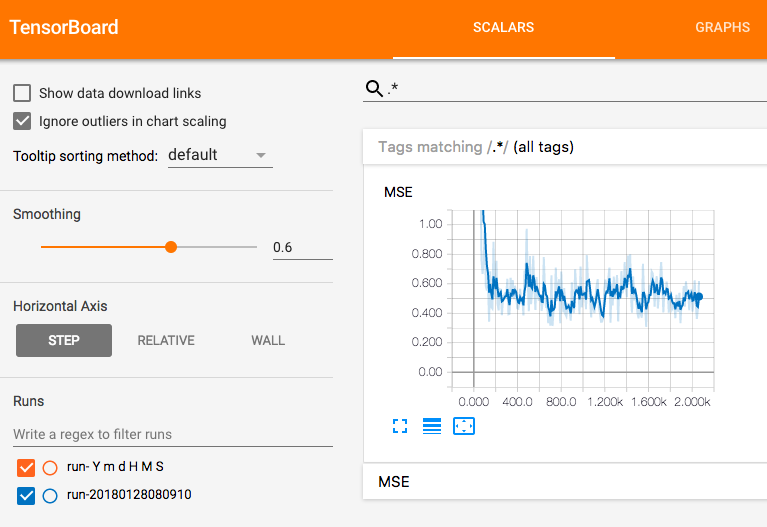

In [33]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh9figure9-3.png"))

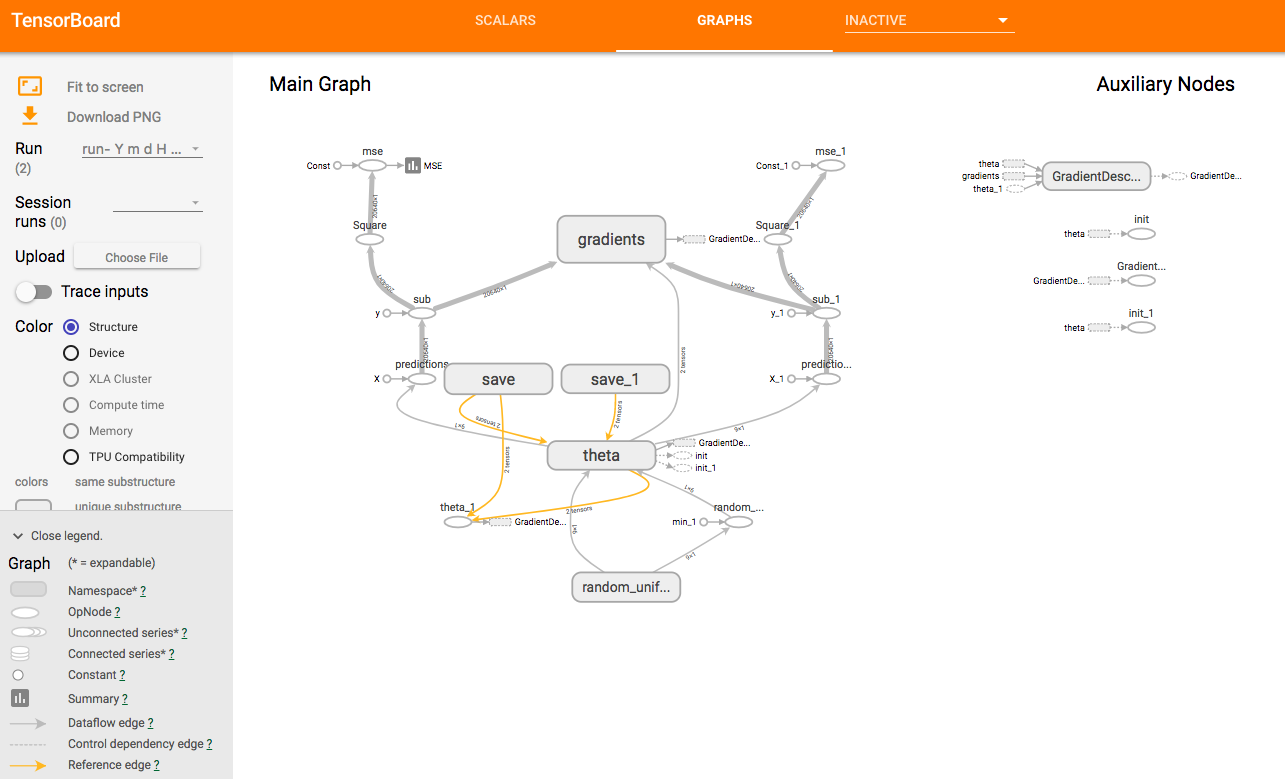

In [38]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh9figure9-4.png"))

- 左の```Main Graph```のうち，他と結合している数が多いノードは右の```Auxiliary Nodes```の詳しく表示されます ．
- いくつかのノードはデフォルトでまとめてあります．たとえば```gradients```ノード，ダブルクリックすると開くことができます．さらにその中の```mse_grad```も下の感じで開くことができます．

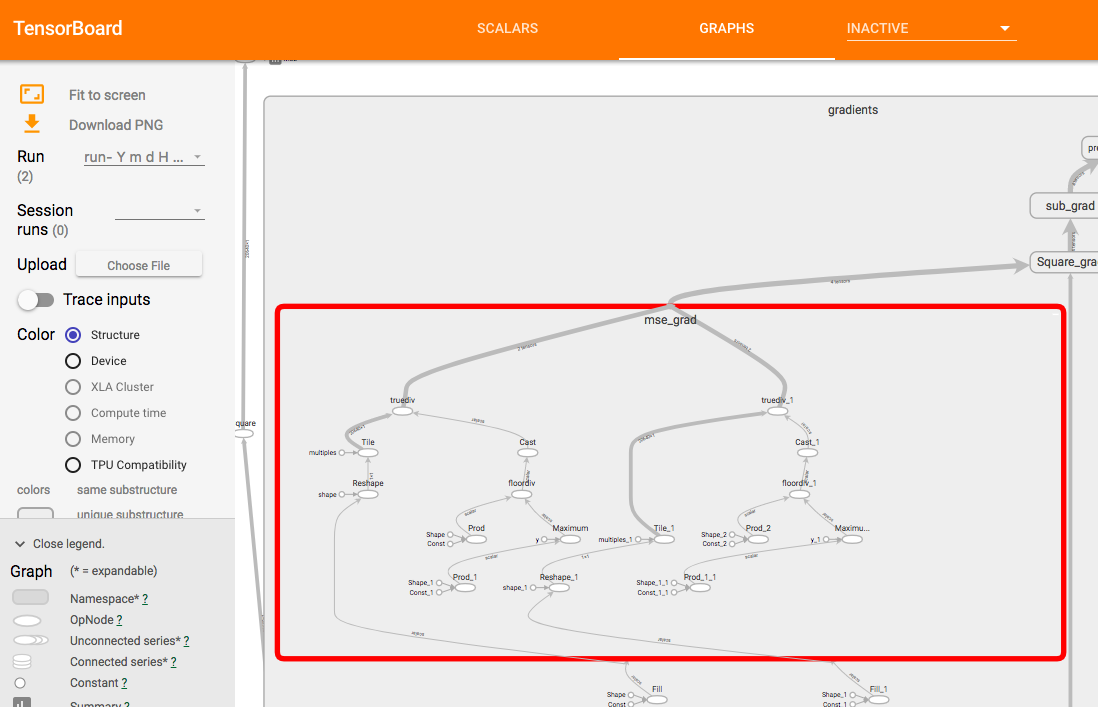

In [40]:
from IPython.display import Image, display_png
display_png(Image("./figures/HandsOnCh9figure9-4-2.png"))

# 9.10 Name Scopes
Neural Networkなどの複雑なモデルを使うときは，何千ものノードが出てきたりしてグラフがすぐにぐちゃぐちゃになってしまいます．これを避けるためにノードのグループ化ができる*name scope*を作ることができます．例えば先ほどのコードの```error```と```mse```opsに```loss```というname scopeをつけましょう．

In [47]:
with tf.name_scope("loss") as scope:
    error = y_pred - y
    mse = tf.reduce_mean( tf.square( error), name ="mse") 

これでname scope```loss```内のopsには```"loss/"```というプレフィクスがつくようになりました．

In [48]:
print( error.op.name)
print( mse.op.name)

loss/sub
loss/mse


TensorBoardでは```mse```と```error```ノードは```loss```namescope内にまとめられて現れるようになります(Figure 9-5).

# 9.11 Modularity